<a href="https://colab.research.google.com/github/SimoneRosset/AUGMENTATION_GAN/blob/master/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## AUGMENTATION_GAN
based on this [paper](https://arxiv.org/pdf/1803.01229.pdf)

In [1]:
!pip install torch-summary

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import torch.optim as optim
import os
from tqdm import notebook
from sklearn.metrics import classification_report, confusion_matrix
from tabulate import tabulate
import gc
import datetime as dt

In [3]:
from google.colab import drive
drive.mount('/content/drive') 
%cd /content/drive/My\ Drive/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive


In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
#plt.style.use('seaborn-white')
import numpy as np
from sklearn.utils.multiclass import unique_labels


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        pass
        #print('Confusion matrix, without normalization')

    #print(cm)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    ax.set_ylim(len(classes)-0.5, -0.5)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [33]:
# functions to show an image

def imshow(img,type_=None,path=None):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    img_=np.transpose(npimg, (1, 2, 0))
    if img_.shape[2]==1:
      img_=img_[:,:,0]
    
    plt.axis('off')
    if type_=='train':
      plt.title('Train Mini-Batch')
    else:
      if type_=='test':
        plt.title('Test Batch')
    plt.imshow(img_, cmap='gray')
    
    if not path == None:
      plt.savefig(path)
    
    plt.show()


In [39]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):

    def _name(self):
        return "CNN"

    def _conv2d(self, in_channels, out_channels):
        return nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            padding=1
        )

    def _build_models(self):
        self.conv1 = nn.Sequential(
            self._conv2d(self.channels_size, self.hidden_size),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size),
            nn.MaxPool2d(2, 2)
        )
        self.conv2 = nn.Sequential(
            self._conv2d(self.hidden_size , self.hidden_size * 2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size * 2),
            nn.MaxPool2d(2, 2)
        )
        self.conv3 = nn.Sequential(
            self._conv2d(self.hidden_size*2, self.hidden_size * 4),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size * 4),
            nn.MaxPool2d(2, 2)
        )
        self.dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear(int(self.hidden_size * 4 * img_dim/8 * img_dim/8), img_dim*4),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(img_dim*4, class_number),
            nn.Softmax(dim=1)
        )
        return self.conv1, self.conv2, self.conv3, self.dense

    def __init__(self, hidden_size, channels_size, class_number):
        super().__init__()
        self.hidden_size = hidden_size
        self.channels_size = channels_size
        self.class_number = class_number
        self._models = self._build_models()
        self.name = self._name()

    def forward(self, image):
        x = self._models[0](image)
        x_1 = self._models[1](x)
        x_2 = self._models[2](x_1)
        x_3 = self._models[3](x_2)
        return x_3

In [7]:
# !git clone https://github.com/vj2050/Transfer-Learning-COVID-19.git

# data_dir_='Transfer-Learning-COVID-19/dataset_4_classes/'

In [8]:
# img_dim=64
# N_rot=3
# N_flip=5
# N_tran=7
# N_scal=3
# transform_list=[]

# transform_list.append(transforms.Grayscale(num_output_channels=1))

# transform_list.append(transforms.Resize((img_dim*2,img_dim*2),interpolation=2))

# for i in range(N_rot):
#   transform_list.append(transforms.RandomApply([transforms.RandomRotation(degrees=(-2,2))], p=0.5))
# for i in range(N_flip):
#   transform_list.append(transforms.RandomHorizontalFlip(p=0.5))
# # for i in range(N_flip):
# #   transform_list.append(transforms.RandomVerticalFlip(p=0.5))
# for i in range(N_scal):
#   transform_list.append(transforms.RandomApply([transforms.RandomAffine(degrees=0,scale=(0.9,1.1))], p=0.5))
# for i in range(N_tran):
#   transform_list.append(transforms.RandomApply([transforms.RandomAffine(degrees=0,translate=(0.1,0.1))], p=0.5))

# transform_list.append(transforms.Resize((img_dim,img_dim),interpolation=2))

# transform_list.append(transforms.ToTensor())

# transform_list.append(transforms.Normalize((0.5), (0.5)))

# transform_ = transforms.Compose(transform_list)

# transform = transforms.Compose([transforms.ToTensor(),
#                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [105]:
batch_size_train=64
batch_size_test=36
num_samples=batch_size_train*4
img_dim=64

data_dir = 'custom_covid_dataset/classic_augment/4_classes'
data_dir_gan = 'custom_covid_dataset/gan_augment/4_classes'

data_dir_new = 'custom_covid_dataset/classic_augment_2/4_classes'
data_dir_new_new = 'custom_covid_dataset/classic_augment_3/4_classes'

transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5))])

# ORIGINAL TRAIN IMAGES
trainset0 = torchvision.datasets.ImageFolder(os.path.join(
          data_dir, "0/"), transform=transform)

# CLASSIC AUGMENTED TRAIN IMAGES
trainset500 = torchvision.datasets.ImageFolder(os.path.join(
          data_dir_new_new, "500/"), transform=transform)
trainset1000 = torchvision.datasets.ImageFolder(os.path.join(
          data_dir_new_new, "1000/"), transform=transform)
trainset2000 = torchvision.datasets.ImageFolder(os.path.join(
          data_dir_new_new, "2000/"), transform=transform)
trainset3000 = torchvision.datasets.ImageFolder(os.path.join(
          data_dir_new_new, "3000/"), transform=transform)

# GAN AUGMENTED TRAIN IMAGES
trainset100_gan = torchvision.datasets.ImageFolder(os.path.join(
          data_dir_gan, "100/"), transform=transform)
trainset500_gan = torchvision.datasets.ImageFolder(os.path.join(
          data_dir_gan, "500/"), transform=transform)
trainset1000_gan = torchvision.datasets.ImageFolder(os.path.join(
          data_dir_gan, "1000/"), transform=transform)
trainset2000_gan = torchvision.datasets.ImageFolder(os.path.join(
          data_dir_gan, "2000/"), transform=transform)

# CONCATENATION LISTS TRAIN IMAGES
listtrainset_no_aug = [trainset0]
listtrainset_classic = [trainset500, trainset1000,trainset2000]
listtrainset_gan = []

listtrainset = listtrainset_no_aug + listtrainset_classic + listtrainset_gan

trainset_concat = torch.utils.data.ConcatDataset(listtrainset)

sampler = torch.utils.data.RandomSampler(trainset_concat,replacement=True, num_samples=num_samples)
trainloader = torch.utils.data.DataLoader(trainset_concat,  sampler=sampler,
                                          batch_size=batch_size_train, drop_last=True)

# TEST IMAGES
testset0 = torchvision.datasets.ImageFolder(os.path.join( 
          data_dir, "test/"), transform=transform)

testloader = torch.utils.data.DataLoader(testset0, batch_size=batch_size_test, shuffle=False)

classes = ("covid", "normal", "pneumonia_bac", "pneumonia_vir")

In [106]:
print(len(trainloader.dataset))

4270


In [107]:
print(len(testloader.dataset))

36


In [108]:
LOAD_MODEL=False
PATH='custom_covid_dataset/results/CNN_1c_D1CLASSIC+D1GAN_2020-08-18 16:43:38.940131/models/CNN_XRAY-COVID19_300e_0.8028888888888824_acc.pth'
hidden_size=32
channels_size=1
class_number=4
METRIC_FIELDS = [ 'loss', 'tot_acc', 'acc', 'sens', 'spec', 'f1_score']
metrics = {field: list() for field in METRIC_FIELDS}
epochs=750

In [109]:
name_new_folder= 'CNN_'+str(channels_size)+'CH_O'+str(len(listtrainset_no_aug))+'+C'+str(len(listtrainset_classic))+'+G'+str(len(listtrainset_gan))+'_{}'.format(dt.datetime.now())
print('NEW FOLDER: ', name_new_folder)
for func in [lambda: os.mkdir(os.path.join('.','custom_covid_dataset/')),
            lambda: os.mkdir(os.path.join('.', 'custom_covid_dataset/results/')),
            lambda: os.mkdir(os.path.join('.', 'custom_covid_dataset/results/'+ name_new_folder +'/')),
            lambda: os.mkdir(os.path.join('.', 'custom_covid_dataset/results/'+ name_new_folder +'/plots/')),
            lambda: os.mkdir(os.path.join('.', 'custom_covid_dataset/results/'+ name_new_folder +'/models/'))]:
  try:
    func()
  except Exception as error:
    print(error)
    continue

NEW FOLDER:  CNN_1CH_O1+C2+G0_2020-08-19 11:03:00.187536
[Errno 17] File exists: './custom_covid_dataset/'
[Errno 17] File exists: './custom_covid_dataset/results/'


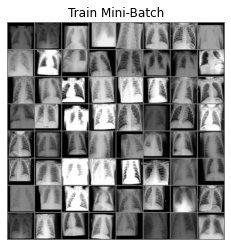

normal pneumonia_vir pneumonia_bac covid pneumonia_vir normal normal pneumonia_bac covid pneumonia_bac covid pneumonia_bac covid covid pneumonia_bac covid pneumonia_bac pneumonia_bac normal pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_bac normal covid covid covid normal pneumonia_vir pneumonia_bac normal normal normal normal pneumonia_vir pneumonia_bac normal pneumonia_bac pneumonia_bac pneumonia_bac normal covid covid pneumonia_vir pneumonia_vir covid pneumonia_bac pneumonia_bac pneumonia_bac covid normal normal normal pneumonia_vir covid normal pneumonia_vir pneumonia_bac pneumonia_bac pneumonia_vir normal pneumonia_vir pneumonia_vir covid


In [110]:
# get some random training images
dataiter = iter(trainloader)
images_train, labels_train = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images_train),type_='train',path='custom_covid_dataset/results/'+ name_new_folder +'/plots/train_mini_batch.png')
# print labels
print(' '.join('%5s' % classes[labels_train[j]] for j in range(batch_size_train)))

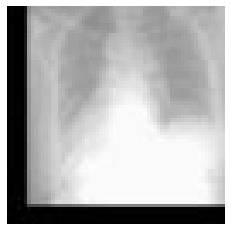

covid


In [111]:
rnd = np.random.randint(0,batch_size_train)
lab_rnd_train=classes[labels_train[rnd]]
imshow(images_train[rnd],path='custom_covid_dataset/results/'+ name_new_folder +'/plots/train_random_%s.png'%(lab_rnd_train))
print(lab_rnd_train)

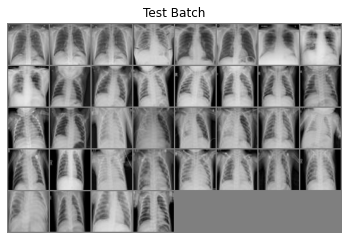

GroundTruth:  covid covid covid covid covid covid covid covid covid normal normal normal normal normal normal normal normal normal pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_vir


In [112]:
dataiter = iter(testloader)
images_test, labels_test = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images_test),type_='test',path='custom_covid_dataset/results/'+ name_new_folder +'/plots/test_batch.png')
print('GroundTruth: ', ' '.join('%5s' % classes[labels_test[j]] for j in range(batch_size_test)))

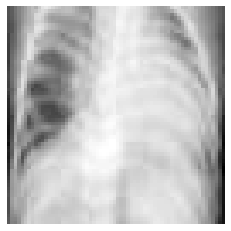

pneumonia_vir


In [113]:
rnd = np.random.randint(0,batch_size_test)
lab_rnd_test = classes[labels_test[rnd]]
imshow(images_test[rnd],path='custom_covid_dataset/results/'+ name_new_folder +'/plots/test_random_%s.png'%(lab_rnd_test))
print(lab_rnd_test)

In [114]:
net=CNN(hidden_size, channels_size, class_number)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

# if LOAD_MODEL: 
#   if torch.cuda.is_available():
#     checkpoint = torch.load(PATH)
#   else:
#     checkpoint = torch.load(PATH, map_location=lambda storage, loc: storage)
              
#   net.load_state_dict(checkpoint['state_dict'])
#   optimizer.load_state_dict(checkpoint['optimizer'])
#   metrics=checkpoint['metrics']
#   net.train(mode=False)
#   print('CNN loaded')
#   for i in checkpoint:
#     print(i, ': ', ((str(checkpoint[i])[:75] + '..') if len(str(checkpoint[i])) > 75 else checkpoint[i]))


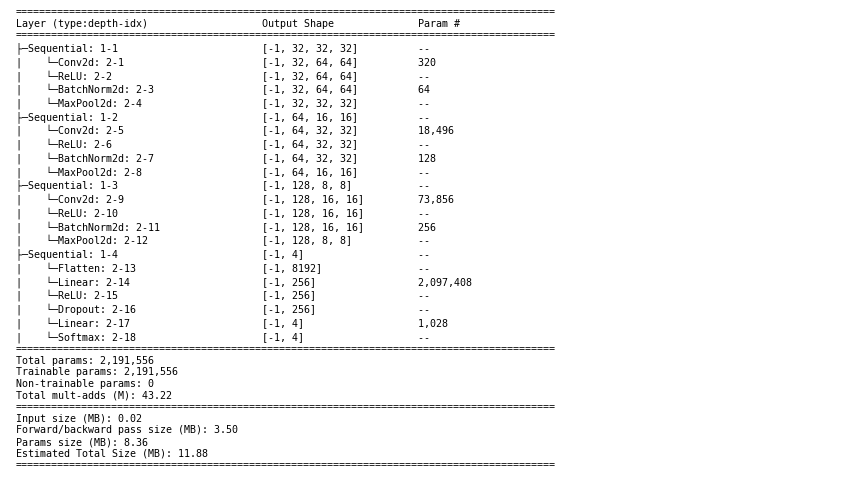

In [115]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

model_stats = summary(net, (channels_size, img_dim, img_dim),verbose=0)
summary_str = str(model_stats)
plt.figure(figsize=(12,7))
plt.text(0.01, 0.05, summary_str, {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig('custom_covid_dataset/results/'+ name_new_folder +'/plots/model_summary.png')


Epoch: [1]  => Loss: [1.388]



Epoch: [2]  => Loss: [1.320]



Epoch: [3]  => Loss: [1.231]



Epoch: [4]  => Loss: [1.248]



Epoch: [5]  => Loss: [1.213]



Epoch: [6]  => Loss: [1.172]



Epoch: [7]  => Loss: [1.151]



Epoch: [8]  => Loss: [1.121]



Epoch: [9]  => Loss: [1.098]



Epoch: [10]  => Loss: [1.122]



Epoch: [10]  => Confusion Matrix Test: [1]  => Total Accuracy over 1800 samples: [0.631]


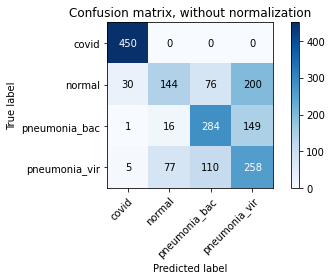

Epoch: [10]  => Evaluation Confusion Matrix Test: [1]
╒══════════════════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│ 4-fold_10_ep_0.631_acc   │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞══════════════════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid                    │      0.98  │         1     │         0.973 │     0.99  │
├──────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal                   │      0.778 │         0.32  │         0.931 │     0.444 │
├──────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac            │      0.804 │         0.631 │         0.862 │     0.705 │
├──────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_vir            │      0.699 │         0.573 │         0.741 │     0.625 │
╘══════════════════════════╧════════════╧═══════════════╧═══════════════╧═══════════╛



Epoch: [11]  => Loss: [1.095]



Epoch: [12]  => Loss: [1.106]



Epoch: [13]  => Loss: [1.119]



Epoch: [14]  => Loss: [1.085]



Epoch: [15]  => Loss: [1.080]



Epoch: [16]  => Loss: [1.099]



Epoch: [17]  => Loss: [1.110]



Epoch: [18]  => Loss: [1.088]



Epoch: [19]  => Loss: [1.074]



Epoch: [20]  => Loss: [1.090]



Epoch: [20]  => Confusion Matrix Test: [2]  => Total Accuracy over 1800 samples: [0.678]


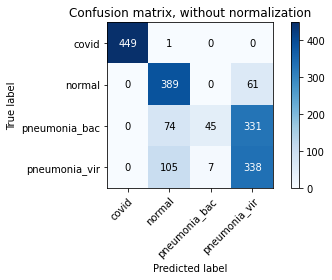

Epoch: [20]  => Evaluation Confusion Matrix Test: [2]
╒══════════════════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│ 4-fold_20_ep_0.678_acc   │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞══════════════════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid                    │      0.999 │         0.998 │         1     │     0.999 │
├──────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal                   │      0.866 │         0.864 │         0.867 │     0.863 │
├──────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac            │      0.771 │         0.1   │         0.995 │     0.163 │
├──────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_vir            │      0.72  │         0.751 │         0.71  │     0.734 │
╘══════════════════════════╧════════════╧═══════════════╧═══════════════╧═══════════╛



Epoch: [21]  => Loss: [1.059]



Epoch: [22]  => Loss: [1.058]



Epoch: [23]  => Loss: [1.031]



Epoch: [24]  => Loss: [1.038]



Epoch: [25]  => Loss: [1.026]



Epoch: [26]  => Loss: [1.015]



Epoch: [27]  => Loss: [1.026]



Epoch: [28]  => Loss: [1.047]



Epoch: [29]  => Loss: [1.060]



Epoch: [30]  => Loss: [1.034]



Epoch: [30]  => Confusion Matrix Test: [3]  => Total Accuracy over 1800 samples: [0.739]


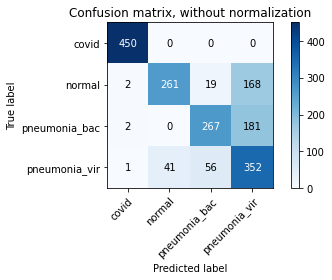

Epoch: [30]  => Evaluation Confusion Matrix Test: [3]
╒══════════════════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│ 4-fold_30_ep_0.739_acc   │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞══════════════════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid                    │      0.997 │         1     │         0.996 │     0.999 │
├──────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal                   │      0.872 │         0.58  │         0.97  │     0.693 │
├──────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac            │      0.857 │         0.593 │         0.944 │     0.698 │
├──────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_vir            │      0.752 │         0.782 │         0.741 │     0.765 │
╘══════════════════════════╧════════════╧═══════════════╧═══════════════╧═══════════╛



Epoch: [31]  => Loss: [1.022]



Epoch: [32]  => Loss: [1.031]



Epoch: [33]  => Loss: [1.033]



Epoch: [34]  => Loss: [1.024]



Epoch: [35]  => Loss: [1.001]



Epoch: [36]  => Loss: [1.046]



Epoch: [37]  => Loss: [1.023]



Epoch: [38]  => Loss: [0.991]



Epoch: [39]  => Loss: [1.013]



Epoch: [40]  => Loss: [1.011]



Epoch: [40]  => Confusion Matrix Test: [4]  => Total Accuracy over 1800 samples: [0.754]


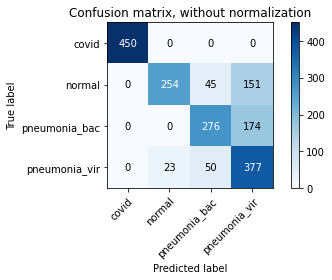

Epoch: [40]  => Evaluation Confusion Matrix Test: [4]
╒══════════════════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│ 4-fold_40_ep_0.754_acc   │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞══════════════════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid                    │      1     │         1     │         1     │     1     │
├──────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal                   │      0.878 │         0.564 │         0.983 │     0.684 │
├──────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac            │      0.851 │         0.613 │         0.93  │     0.71  │
├──────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_vir            │      0.779 │         0.838 │         0.759 │     0.805 │
╘══════════════════════════╧════════════╧═══════════════╧═══════════════╧═══════════╛



Epoch: [41]  => Loss: [0.968]



Epoch: [42]  => Loss: [0.997]



Epoch: [43]  => Loss: [1.006]



Epoch: [44]  => Loss: [0.994]



Epoch: [45]  => Loss: [0.974]



Epoch: [46]  => Loss: [0.988]



Epoch: [47]  => Loss: [0.988]



Epoch: [48]  => Loss: [0.982]



Epoch: [49]  => Loss: [0.979]



Epoch: [50]  => Loss: [0.965]



Epoch: [50]  => Confusion Matrix Test: [5]  => Total Accuracy over 1800 samples: [0.732]


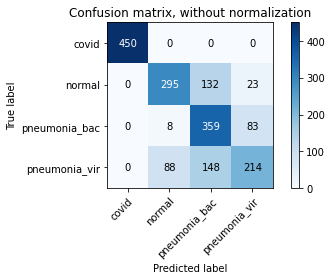

Epoch: [50]  => Evaluation Confusion Matrix Test: [5]
╒══════════════════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│ 4-fold_50_ep_0.732_acc   │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞══════════════════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid                    │      1     │         1     │         1     │     1     │
├──────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal                   │      0.861 │         0.656 │         0.929 │     0.742 │
├──────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac            │      0.794 │         0.798 │         0.793 │     0.794 │
├──────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_vir            │      0.81  │         0.476 │         0.921 │     0.591 │
╘══════════════════════════╧════════════╧═══════════════╧═══════════════╧═══════════╛



Epoch: [51]  => Loss: [0.942]



Epoch: [52]  => Loss: [0.980]



Epoch: [53]  => Loss: [0.962]



Epoch: [54]  => Loss: [0.961]



Epoch: [55]  => Loss: [0.978]



Epoch: [56]  => Loss: [0.930]



Epoch: [57]  => Loss: [0.984]



Epoch: [58]  => Loss: [0.973]



Epoch: [59]  => Loss: [0.979]



Epoch: [60]  => Loss: [0.930]



Epoch: [60]  => Confusion Matrix Test: [6]  => Total Accuracy over 1800 samples: [0.767]


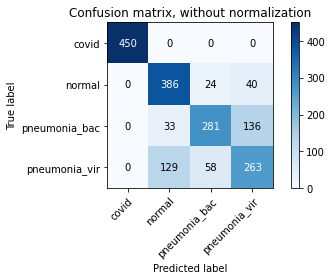

Epoch: [60]  => Evaluation Confusion Matrix Test: [6]
╒══════════════════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│ 4-fold_60_ep_0.767_acc   │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞══════════════════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid                    │      1     │         1     │         1     │     1     │
├──────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal                   │      0.874 │         0.858 │         0.88  │     0.865 │
├──────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac            │      0.861 │         0.624 │         0.939 │     0.72  │
├──────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_vir            │      0.798 │         0.584 │         0.87  │     0.671 │
╘══════════════════════════╧════════════╧═══════════════╧═══════════════╧═══════════╛



Epoch: [61]  => Loss: [1.001]



Epoch: [62]  => Loss: [1.006]



Epoch: [63]  => Loss: [0.907]



Epoch: [64]  => Loss: [1.001]



Epoch: [65]  => Loss: [0.993]



Epoch: [66]  => Loss: [0.968]



Epoch: [67]  => Loss: [0.909]



Epoch: [68]  => Loss: [0.976]



Epoch: [69]  => Loss: [0.984]



Epoch: [70]  => Loss: [0.938]



Epoch: [70]  => Confusion Matrix Test: [7]  => Total Accuracy over 1800 samples: [0.674]


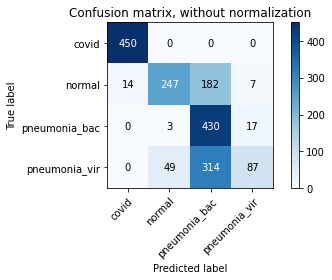

Epoch: [70]  => Evaluation Confusion Matrix Test: [7]
╒══════════════════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│ 4-fold_70_ep_0.674_acc   │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞══════════════════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid                    │      0.992 │         1     │         0.99  │     0.996 │
├──────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal                   │      0.858 │         0.549 │         0.961 │     0.665 │
├──────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac            │      0.713 │         0.956 │         0.633 │     0.816 │
├──────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_vir            │      0.785 │         0.193 │         0.982 │     0.301 │
╘══════════════════════════╧════════════╧═══════════════╧═══════════════╧═══════════╛



Epoch: [71]  => Loss: [0.977]



Epoch: [72]  => Loss: [0.963]



Epoch: [73]  => Loss: [0.966]



Epoch: [74]  => Loss: [0.951]



Epoch: [75]  => Loss: [0.933]



Epoch: [76]  => Loss: [0.962]



Epoch: [77]  => Loss: [1.008]



Epoch: [78]  => Loss: [0.981]



Epoch: [79]  => Loss: [0.952]



Epoch: [80]  => Loss: [1.025]



Epoch: [80]  => Confusion Matrix Test: [8]  => Total Accuracy over 1800 samples: [0.714]


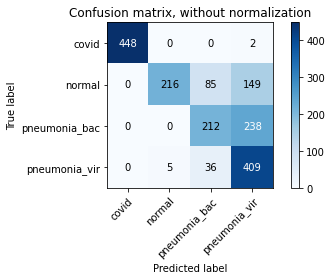

Epoch: [80]  => Evaluation Confusion Matrix Test: [8]
╒══════════════════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│ 4-fold_80_ep_0.714_acc   │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞══════════════════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid                    │      0.999 │         0.996 │         1     │     0.997 │
├──────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal                   │      0.867 │         0.48  │         0.996 │     0.614 │
├──────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac            │      0.801 │         0.471 │         0.91  │     0.587 │
├──────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_vir            │      0.761 │         0.909 │         0.712 │     0.827 │
╘══════════════════════════╧════════════╧═══════════════╧═══════════════╧═══════════╛



Epoch: [81]  => Loss: [0.955]



Epoch: [82]  => Loss: [0.964]



Epoch: [83]  => Loss: [0.980]



Epoch: [84]  => Loss: [0.986]



Epoch: [85]  => Loss: [0.967]



Epoch: [86]  => Loss: [0.894]



Epoch: [87]  => Loss: [0.952]



Epoch: [88]  => Loss: [0.903]



Epoch: [89]  => Loss: [0.964]



Epoch: [90]  => Loss: [0.974]



Epoch: [90]  => Confusion Matrix Test: [9]  => Total Accuracy over 1800 samples: [0.702]


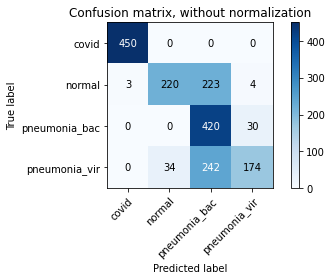

Epoch: [90]  => Evaluation Confusion Matrix Test: [9]
╒══════════════════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│ 4-fold_90_ep_0.702_acc   │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞══════════════════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid                    │      0.998 │         1     │         0.998 │     0.999 │
├──────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal                   │      0.853 │         0.489 │         0.975 │     0.615 │
├──────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac            │      0.725 │         0.933 │         0.656 │     0.815 │
├──────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_vir            │      0.828 │         0.387 │         0.975 │     0.516 │
╘══════════════════════════╧════════════╧═══════════════╧═══════════════╧═══════════╛



Epoch: [91]  => Loss: [0.921]



Epoch: [92]  => Loss: [0.931]



Epoch: [93]  => Loss: [0.947]



Epoch: [94]  => Loss: [0.929]



Epoch: [95]  => Loss: [1.003]



Epoch: [96]  => Loss: [0.926]



Epoch: [97]  => Loss: [0.923]



Epoch: [98]  => Loss: [0.935]



Epoch: [99]  => Loss: [0.984]



Epoch: [100]  => Loss: [0.941]



Epoch: [100]  => Confusion Matrix Test: [10]  => Total Accuracy over 1800 samples: [0.728]


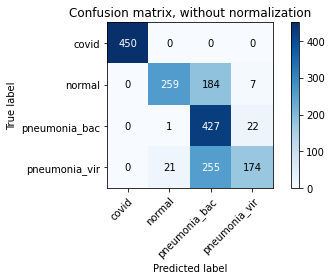

Epoch: [100]  => Evaluation Confusion Matrix Test: [10]
╒═══════════════════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│ 4-fold_100_ep_0.728_acc   │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid                     │      1     │         1     │         1     │     1     │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal                    │      0.882 │         0.576 │         0.984 │     0.695 │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac             │      0.743 │         0.949 │         0.675 │     0.833 │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_vir             │      0.831 │         0.387 │         0.979 │     0.52  │
╘═══════════════════════════╧════════════╧═══════════════╧═══════════════╧


Epoch: [101]  => Loss: [0.942]



Epoch: [102]  => Loss: [0.928]



Epoch: [103]  => Loss: [0.912]



Epoch: [104]  => Loss: [1.006]



Epoch: [105]  => Loss: [0.984]



Epoch: [106]  => Loss: [0.988]



Epoch: [107]  => Loss: [1.016]



Epoch: [108]  => Loss: [0.972]



Epoch: [109]  => Loss: [0.977]



Epoch: [110]  => Loss: [0.934]



Epoch: [110]  => Confusion Matrix Test: [11]  => Total Accuracy over 1800 samples: [0.703]


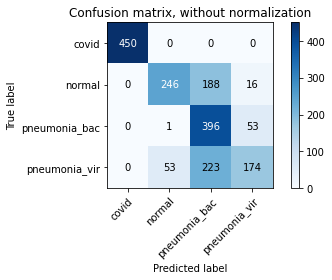

Epoch: [110]  => Evaluation Confusion Matrix Test: [11]
╒═══════════════════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│ 4-fold_110_ep_0.703_acc   │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid                     │      1     │         1     │         1     │     1     │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal                    │      0.857 │         0.547 │         0.96  │     0.664 │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac             │      0.742 │         0.88  │         0.696 │     0.804 │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_vir             │      0.808 │         0.387 │         0.949 │     0.517 │
╘═══════════════════════════╧════════════╧═══════════════╧═══════════════╧


Epoch: [111]  => Loss: [0.930]



Epoch: [112]  => Loss: [0.953]



Epoch: [113]  => Loss: [0.957]



Epoch: [114]  => Loss: [0.937]



Epoch: [115]  => Loss: [0.920]



Epoch: [116]  => Loss: [0.994]



Epoch: [117]  => Loss: [0.937]



Epoch: [118]  => Loss: [0.935]



Epoch: [119]  => Loss: [0.946]



Epoch: [120]  => Loss: [0.935]



Epoch: [120]  => Confusion Matrix Test: [12]  => Total Accuracy over 1800 samples: [0.768]


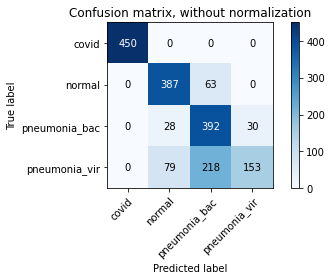

Epoch: [120]  => Evaluation Confusion Matrix Test: [12]
╒═══════════════════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│ 4-fold_120_ep_0.768_acc   │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid                     │      1     │         1     │         1     │     1     │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal                    │      0.906 │         0.86  │         0.921 │     0.881 │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac             │      0.812 │         0.871 │         0.792 │     0.84  │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_vir             │      0.818 │         0.34  │         0.978 │     0.476 │
╘═══════════════════════════╧════════════╧═══════════════╧═══════════════╧


Epoch: [121]  => Loss: [0.888]



Epoch: [122]  => Loss: [0.908]



Epoch: [123]  => Loss: [0.871]



Epoch: [124]  => Loss: [0.909]



Epoch: [125]  => Loss: [0.919]



Epoch: [126]  => Loss: [0.906]



Epoch: [127]  => Loss: [0.921]



Epoch: [128]  => Loss: [0.892]



Epoch: [129]  => Loss: [0.927]



Epoch: [130]  => Loss: [0.932]



Epoch: [130]  => Confusion Matrix Test: [13]  => Total Accuracy over 1800 samples: [0.813]


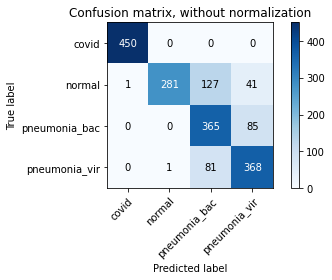

Epoch: [130]  => Evaluation Confusion Matrix Test: [13]
╒═══════════════════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│ 4-fold_130_ep_0.813_acc   │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid                     │      0.999 │         1     │         0.999 │     1     │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal                    │      0.906 │         0.624 │         0.999 │     0.736 │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac             │      0.837 │         0.811 │         0.846 │     0.822 │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_vir             │      0.884 │         0.818 │         0.907 │     0.848 │
╘═══════════════════════════╧════════════╧═══════════════╧═══════════════╧


Epoch: [131]  => Loss: [0.919]



Epoch: [132]  => Loss: [0.939]



Epoch: [133]  => Loss: [0.913]



Epoch: [134]  => Loss: [0.931]



Epoch: [135]  => Loss: [0.887]



Epoch: [136]  => Loss: [0.913]



Epoch: [137]  => Loss: [0.919]



Epoch: [138]  => Loss: [0.880]



Epoch: [139]  => Loss: [0.926]



Epoch: [140]  => Loss: [0.898]



Epoch: [140]  => Confusion Matrix Test: [14]  => Total Accuracy over 1800 samples: [0.796]


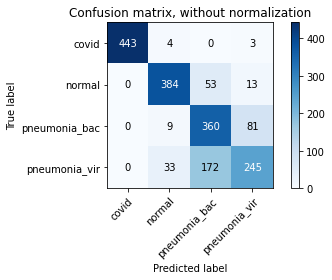

Epoch: [140]  => Evaluation Confusion Matrix Test: [14]
╒═══════════════════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│ 4-fold_140_ep_0.796_acc   │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid                     │      0.996 │         0.984 │         1     │     0.99  │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal                    │      0.938 │         0.853 │         0.966 │     0.891 │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac             │      0.825 │         0.8   │         0.833 │     0.811 │
├───────────────────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_vir             │      0.832 │         0.544 │         0.928 │     0.655 │
╘═══════════════════════════╧════════════╧═══════════════╧═══════════════╧


Epoch: [141]  => Loss: [0.884]



Epoch: [142]  => Loss: [0.919]



Epoch: [143]  => Loss: [0.857]



Epoch: [144]  => Loss: [0.883]



Epoch: [145]  => Loss: [0.907]



Epoch: [146]  => Loss: [0.875]



Epoch: [147]  => Loss: [0.881]



Epoch: [148]  => Loss: [0.891]



Epoch: [149]  => Loss: [0.920]



Epoch: [150]  => Loss: [0.882]


In [ ]:
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for data in notebook.tqdm(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        
        gc.collect()
        if torch.cuda.is_available():
            inputs, labels = data[0].cuda(), data[1].cuda()  
        else:
            inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    print("Epoch: [%d]"%(epoch + 1),' => Loss: [%.3f]' %(running_loss / len(trainloader)))
    if (epoch+1)%10==0:
        with torch.no_grad():
            metrics['loss'].append([epoch+1, (running_loss / len(trainloader))])
            accuracy_tot = list(0. for i in range(len(classes)))
            sensitivity_tot = list(0. for i in range(len(classes)))
            specificity_tot = list(0. for i in range(len(classes)))
            f1score_tot = list(0. for i in range(len(classes)))
            table = list(0. for i in range(len(classes)))
            tot_acc_tot=0

            iterations=50
            if (epoch+1)%150==0:
              iterations=500
  
            labels_tot=np.array([],dtype=np.uint8)
            predicted_tot=np.array([],dtype=np.uint8)

            for i in notebook.tqdm(range(iterations)):
              dataiter = iter(testloader)
              images, labels = dataiter.next()

              outputs = net(images.to(device))

              _, predicted = torch.max(outputs, 1)

              labels_tot=np.append(labels_tot,labels.cpu().detach().numpy())
              predicted_tot=np.append(predicted_tot,predicted.cpu().detach().numpy())

              cm = confusion_matrix(labels.cpu().detach().numpy(), predicted.cpu().detach().numpy(), labels=None, sample_weight=None)

              tot_acc=np.trace(cm)/np.sum(cm)

              tot_acc_tot+=tot_acc

              sensitivity = list(0. for i in range(cm.shape[0]))
              specificity = list(0. for i in range(cm.shape[0]))
              accuracy = list(0. for i in range(cm.shape[0]))
              f1score = list(0. for i in range(cm.shape[0]))

              for i in range(cm.shape[0]):
                TP = cm[i,i]
                FN = np.sum(cm[i,:]) - TP
                FP = np.sum(cm[:,i]) - TP
                TN = (np.sum(cm) - TP - FP - FN)
                accuracy[i] = (TP + TN) / (TP + TN + FP + FN) 
                sensitivity[i] = TP / (TP + FN) 
                specificity[i] = TN / (TN + FP) 
                f1score[i]= 2 * (accuracy[i] * sensitivity[i]) / (accuracy[i] + sensitivity[i])
              accuracy_tot = [sum(x) for x in zip(accuracy_tot, accuracy)]
              specificity_tot = [sum(x) for x in zip(specificity_tot, specificity)]
              sensitivity_tot = [sum(x) for x in zip(sensitivity_tot, sensitivity)]
              f1score_tot = [sum(x) for x in zip(f1score_tot, f1score)]
              
            accuracy_tot = [round((x/iterations),3) for x in accuracy_tot]
            specificity_tot = [round((x/iterations),3) for x in specificity_tot]
            sensitivity_tot = [round((x/iterations),3) for x in sensitivity_tot]
            f1score_tot = [round((x/iterations),3) for x in f1score_tot]
            tot_acc_tot/=iterations
            running_loss/=(iterations*len(testloader))

            metrics['tot_acc'].append([epoch+1, tot_acc_tot])
            metrics['acc'].append([epoch+1, accuracy_tot])
            metrics['spec'].append([epoch+1, specificity_tot])
            metrics['sens'].append([epoch+1, sensitivity_tot])
            metrics['f1_score'].append([epoch+1, f1score_tot])

            table=[classes, accuracy_tot, sensitivity_tot, specificity_tot, f1score_tot]
            table=np.array(table).T.tolist()

            plot_confusion_matrix(labels_tot, predicted_tot, classes=np.asarray(classes), normalize=False)
            
            print("Epoch: [%d]"%(epoch + 1)," => Confusion Matrix Test: [%d]" %(int((epoch+1)/10))," => Total Accuracy over %d samples: [%.3f]" %(len(testloader.dataset)*iterations, tot_acc_tot))

            if (epoch+1)%150==0:
              plt.gcf().savefig('custom_covid_dataset/results/'+ name_new_folder +'/plots/confusion_matrix_%d_ep_%.3f_acc.png' % ((epoch + 1),tot_acc_tot))
            
            plt.show()

            print("Epoch: [%d]"%(epoch + 1)," => Evaluation Confusion Matrix Test: [%d]" %(int((epoch+1)/10)))

            tab = tabulate(table, headers=['%d-fold_%d_ep_%.3f_acc' % (len(classes),(epoch + 1),tot_acc_tot),'Accuracy','Sensitivity', 'Specificity', 'F1Score'], tablefmt='fancy_grid')

            if (epoch+1)%150==0:
              plt.figure(figsize=(8,2.5))
              plt.text(0.01, 0.05, tab, {'fontsize': 10}, fontproperties = 'monospace') 
              plt.axis('off')
              plt.tight_layout()
              plt.savefig('custom_covid_dataset/results/'+ name_new_folder +'/plots/k_fold_%d_ep_%.3f_acc.png' % ((epoch + 1),tot_acc_tot))
              plt.show()
            else:
              print(tab)

            if (epoch+1)%150==0:
              PATH = 'custom_covid_dataset/results/'+ name_new_folder +'/models/'
              NAME = 'CNN_XRAY-COVID19_'+str(epoch+1)+'EP_'+str(round(tot_acc_tot,3))+'ACC_O'+str(len(listtrainset_no_aug))+'+C'+str(len(listtrainset_classic))+'+G'+str(len(listtrainset_gan))
              EXT = '.pth'
              states = {
                      'state_dict': net.state_dict(),
                      'optimizer': optimizer.state_dict(),
                      'device': device,
                      'classes': classes,
                      'metrics': metrics,
                      'train_epoch': epoch+1,
                      'dataset_code': 'O'+str(len(listtrainset_no_aug))+'+C'+str(len(listtrainset_classic))+'+G'+str(len(listtrainset_gan)),
                      'dataset_length': len(trainloader.dataset),
                      'batch': num_samples,
                      'mini-batch': batch_size_train,
                      'img_dim': (img_dim,img_dim,channels_size),
                      'date': dt.datetime.now().strftime("%Y-%m-%d_%H:%M:%S"),
              }
              torch.save(states, PATH+NAME+EXT)
              fig = plt.figure(figsize=(25,15))
              fig.suptitle(NAME, fontsize=16)
              fig.subplots_adjust(hspace=0.2, wspace=0.2)
              for i in range(1, len(METRIC_FIELDS)+1):
                  ax = fig.add_subplot(2, 3, i)
                  if type(metrics[METRIC_FIELDS[i-1]][1][1])==list:
                    for j in range(len(classes)):
                      ax.plot([x[0] for x in metrics[METRIC_FIELDS[i-1]]],[x[1][j] for x in metrics[METRIC_FIELDS[i-1]]], label=classes[j])
                    ax.legend()
                  else:
                    ax.plot([x[0] for x in metrics[METRIC_FIELDS[i-1]]],[x[1] for x in metrics[METRIC_FIELDS[i-1]]])
                  ax.set(ylabel=METRIC_FIELDS[i-1],xlabel='epochs')
              get_fig = plt.gcf()
              get_fig.savefig('custom_covid_dataset/results/'+ name_new_folder +'/plots/%s.png' % (NAME))
              plt.show()
    running_loss = 0.0
print('Finished Training')


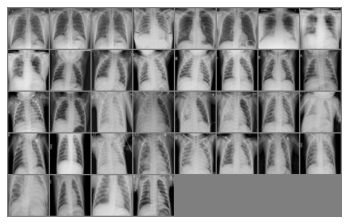

GroundTruth:  covid covid covid covid covid covid covid covid covid normal normal normal normal normal normal normal normal normal pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_vir
Predicted:  covid covid covid covid covid covid covid covid covid pneumonia_bac normal pneumonia_bac normal pneumonia_bac normal normal normal normal pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_vir pneumonia_vir pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_vir pneumonia_vir pneumonia_bac pneumonia_bac


In [104]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(batch_size_test)))
outputs = net(images.to(device))

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(batch_size_test)))

In [ ]:
print(classification_report(labels.cpu().detach().numpy(), predicted.cpu().detach().numpy(), labels=None, target_names=classes, digits=3))

In [ ]:
accuracy_tot = list(0. for i in range(cm.shape[0]))
sensitivity_tot = list(0. for i in range(cm.shape[0]))
specificity_tot = list(0. for i in range(cm.shape[0]))
f1score_tot = list(0. for i in range(cm.shape[0]))
table = list(0. for i in range(cm.shape[0]))
tot_acc_tot=0

iterations=500
labels_tot=np.array([],dtype=np.uint8)
predicted_tot=np.array([],dtype=np.uint8)

with torch.no_grad():
  for i in notebook.tqdm(range(iterations)):
    dataiter = iter(testloader)
    images, labels = dataiter.next()

    outputs = net(images.to(device))

    _, predicted = torch.max(outputs, 1)

    labels_tot=np.append(labels_tot,labels.cpu().detach().numpy())
    predicted_tot=np.append(predicted_tot,predicted.cpu().detach().numpy())

    cm = confusion_matrix(labels.cpu().detach().numpy(), predicted.cpu().detach().numpy(), labels=None, sample_weight=None)

    tot_acc=np.trace(cm)/np.sum(cm)

    tot_acc_tot+=tot_acc

    sensitivity = list(0. for i in range(cm.shape[0]))
    specificity = list(0. for i in range(cm.shape[0]))
    accuracy = list(0. for i in range(cm.shape[0]))
    f1score = list(0. for i in range(cm.shape[0]))

    for i in range(cm.shape[0]):
      TP = cm[i,i]
      FN = np.sum(cm[i,:]) - TP
      FP = np.sum(cm[:,i]) - TP
      TN = (np.sum(cm) - TP - FP - FN)
      accuracy[i] = (TP + TN) / (TP + TN + FP + FN) 
      sensitivity[i] = TP / (TP + FN) 
      specificity[i] = TN / (TN + FP) 
      f1score[i]= 2 * (accuracy[i] * sensitivity[i]) / (accuracy[i] + sensitivity[i])
    accuracy_tot = [sum(x) for x in zip(accuracy_tot, accuracy)]
    specificity_tot = [sum(x) for x in zip(specificity_tot, specificity)]
    sensitivity_tot = [sum(x) for x in zip(sensitivity_tot, sensitivity)]
    f1score_tot = [sum(x) for x in zip(f1score_tot, f1score)]
    
  accuracy_tot = [round((x/iterations),3) for x in accuracy_tot]
  specificity_tot = [round((x/iterations),3) for x in specificity_tot]
  sensitivity_tot = [round((x/iterations),3) for x in sensitivity_tot]
  f1score_tot = [round((x/iterations),3) for x in f1score_tot]
  tot_acc_tot/=iterations

  table=[classes, accuracy_tot, sensitivity_tot, specificity_tot, f1score_tot]

  table=np.array(table).T.tolist()

  plot_confusion_matrix(labels_tot, predicted_tot, classes=np.asarray(classes), normalize=False)

  print("Total Accuracy over %d samples: [%.3f]" %(len(testloader.dataset)*iterations, tot_acc_tot))

  plt.show()

  print(tabulate(table, headers=['Accuracy','Sensitivity', 'Specificity', 'F1Score'], tablefmt='fancy_grid'))


Reference to estimated values

<img src="https://devopedia.org/images/article/208/6541.1566280388.jpg" alt="Drawing" width= '400px'/>
